# Regression


## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
%matplotlib inline

## EDA

* Load the data
* Look at the `median_house_value` variable. Does it have a long tail?

In [2]:
df = pd.read_csv("./data/housing.csv")

Text(0, 0.5, 'Frequency')

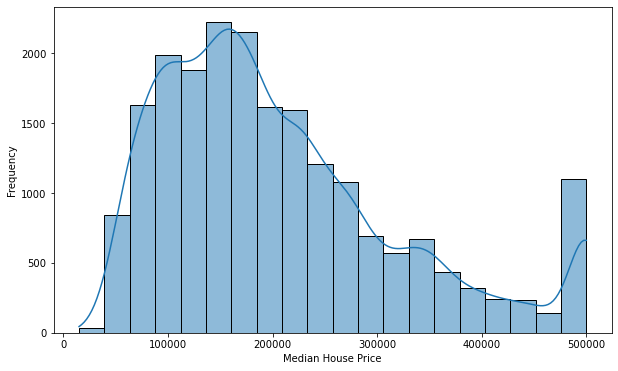

In [3]:
plt.figure(figsize=(10,6))
sns.histplot(df["median_house_value"],bins=20,kde=True);
plt.xlabel("Median House Price")
plt.ylabel("Frequency")

## Features

In [4]:

cols = ["latitude","longitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]
df_hw = df[cols]
df_hw.columns

Index(['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

## Question 1

Find a feature with missing values. How many missing values does it have?

In [5]:
missing_value_cols = [col for col in df_hw.columns if df_hw[col].isnull().sum()]
missing_value_cols

['total_bedrooms']

In [6]:
df[missing_value_cols].isnull().sum()

total_bedrooms    207
dtype: int64

## Question 2

What's the median(50 % percentile) for variable 'population'?

In [7]:
df["population"].describe()

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: population, dtype: float64

The 50% percentile is 1166

## Split the data

* Shuffle the initial dataset, use seed `42`.
* Split the data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('median_house_value') is not in your dataframe
* Apply the log transformation to the median_house_value variable using the `np.log1p()` function

In [8]:
# Set seed to 42
np.random.seed(42)
# size of  the dataframe
n = len(df_hw)
# setting the size of validation,test and train to 20,20 and 60% respectively

n_val = int (0.2*n)
n_test = int (0.2*n)
n_train = n - (n_val + n_test)

# Generating a range of index and shuffling the index
idx = np.arange(n)
np.random.shuffle(idx)

# Creating shuffled dataframe
df_shuffled = df_hw.iloc[idx]

# Splitting the shuffled data into train,val and test sets
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()


# Creating target variable

y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

# Applying log transformation to the medain_house_value
y_train = np.log1p(df_train["median_house_value"].values)
y_val = np.log1p(df_val["median_house_value"].values)
y_test = np.log1p(df_test["median_house_value"].values)

# Deleting column "median_house_value"

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


## Question 3
* Fill the missing values with 0 and with mean of this variable.
* For each, train a linear regression model without regularization
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and comparte the RMSe of each options
* Round the RMSE scores to 2 decimal digits using `round(score,2)`
* Which option gives better RMSE?

In [9]:
df_train_copy = df_train.copy()
# Filling missing value with mean
df_train_mean = df_train_copy.fillna(df[missing_value_cols].mean(),axis=0)
# Filling missing value with 0
df_train_zero = df_train_copy.fillna(0,axis=0)

In [10]:
def linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [15]:
def rmse(y,y_pred):
    se = (y-y_pred)
    mse = (se**2).mean()
    return np.sqrt(mse)

In [12]:
def make_predictions(w0,w,X_val):
    return w0+X_val.dot(w)

In [16]:
def model(X,y,X_val,y_val):
    w0,w = linear_regression(X,y)
    y_pred = make_predictions(w0,w,X_val)
    score = round(rmse(y_val,y_pred),2)
    params = {
        "w0":w0,
        "w":w,
        "score":score
    }
    return params

In [17]:
param_1 = model(df_train_zero,y_train,df_val,y_val)
print(f" (For 0 filled data) Score is {param_1['score']}")
param_2 = model(df_train_mean,y_train,df_val,y_val)
print(f" (For mean filled data) Score is {param_2['score']}")

 (For 0 filled data) Score is 0.33
 (For mean filled data) Score is 0.33


Both gives better results.

## Question 4
* Now let's train a regularized linear regression
* For this question, fill the NAs with 0.
* Try different values of `r` from the list: `[0,0.000001,0.0001,0.001,0.01,0.1,1,5,10]`
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

In [18]:
def linear_regression_reg(X,y,r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0],w_full[1:] 

In [19]:
def model_with_regularization(X,y,X_test,y_test,r):
    w0,w = linear_regression_reg(X,y,r)
    y_pred = make_predictions(w0,w,X_test)
    score = round(rmse(y_test,y_pred),2)
    params = {
        "r":r,
        "w0":w0,
        "w":w,
        "score":score
    }
    return params

In [20]:
print("(r,score)")
df_train = df_train.fillna(0,axis=0)
for r in [0,0.000001,0.0001,0.001,0.01,0.1,1,5,10]:
    params = model_with_regularization(df_train,y_train,df_val,y_val,r)
    print(f"{params['r'],params['score']}")

(r,score)
(0, 0.33)
(1e-06, 0.33)
(0.0001, 0.33)
(0.001, 0.33)
(0.01, 0.33)
(0.1, 0.33)
(1, 0.33)
(5, 0.34)
(10, 0.34)


r with 0 gives the best score.

## Question 5
* Try different seed values: `[0,1,2,3,4,5,6,7,8,9]`
* For each seed, do the train/validatoin/test splt with 60%/20%/20% distrubution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE score.
* What's the standard deviation of all the scores?
* Round the reuslt to 3 decimal digits

In [56]:
for s in range(0,10):
    # Set seed to s
    np.random.seed(s)
    
    # size of  the dataframe
    n = len(df_hw)
    # setting the size of validation,test and train to 20,20 and 60% respectively
    n_val = int (0.2*n)
    n_test = int (0.2*n)
    n_train = n - (n_val + n_test)

    # Generating a range of index and shuffling the index
    idx = np.arange(n)
    np.random.shuffle(idx)

    # Creating shuffled dataframe
    df_shuffled = df_hw.iloc[idx]

    # Splitting the shuffled data into train,val and test sets
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    
     # Filling the missing values with 0
    df_train = df_train.fillna(0,axis=0)
    df_val = df_val.fillna(0,axis=0)
    df_test = df_val.fillna(0,axis=0)


    # Creating target variable

    y_train = df_train['median_house_value']
    y_val = df_val['median_house_value']
    y_test = df_test['median_house_value']

    # Applying log transformation to the medain_house_value
    y_train = np.log1p(df_train["median_house_value"].values)
    y_val = np.log1p(df_val["median_house_value"].values)
    y_test = np.log1p(df_test["median_house_value"].values)
    
    

    # Deleting column "medain_house_value"

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
   
    
    params =  model_with_regularization(df_train,y_train,df_val,y_val,0)
    print(params["score"])
    

0.34
0.34
0.33
0.34
0.34
0.34
0.35
0.34
0.35
0.34


In [57]:
round(np.std(params["score"]),3)

0.0

## Question 6
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`
* What's the RMSE on the test dataset.

In [53]:
# Set seed to 9
np.random.seed(9)
# size of  the dataframe
n = len(df_hw)
# setting the size of validation,test and train to 20,20 and 60% respectively

n_val = int (0.2*n)
n_test = int (0.2*n)
n_train = n - (n_val + n_test)

# Generating a range of index and shuffling the index
idx = np.arange(n)
np.random.shuffle(idx)

# Creating shuffled dataframe
df_shuffled = df_hw.iloc[idx]

# Splitting the shuffled data into train,val and test sets
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()


df_train = df_train.fillna(0,axis=0)
df_val = df_val.fillna(0,axis=0)
df_test = df_val.fillna(0,axis=0)

# Creating target variable

y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

# Applying log transformation to the medain_house_value
y_train = np.log1p(df_train["median_house_value"].values)
y_val = np.log1p(df_val["median_house_value"].values)
y_test = np.log1p(df_test["median_house_value"].values)

# Deleting column "medain_house_value"

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']



# Combining train and validation dataset

df_full_train = pd.concat([df_train,df_val])

df_full_train = df_full_train.reset_index(drop=True)
y_full_train = np.concatenate([y_train,y_val])

In [54]:
params = model_with_regularization(df_full_train,y_full_train,df_test,y_test,r=0.001)

In [55]:
params["score"]

0.34